In [176]:
from configparser import ConfigParser

import numpy as np
import plotly.graph_objects as go
from IPython.display import Image

from src.root_path import config_path, root_path
from src.visualization.palette import *

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


In [240]:
MODEL_COLORMAP = {'matchl_STRF': Orange,
                  'matchl_self': Blue,
                  'matchl_pop': Green,
                  'matchl_full': Purple}


def poissonSpikeGen(fr, binSim, nTrials):
    tSim = binSim / 100  # 100 hz resolution for models
    dt = 1 / 1000  # ms resolution for nicer plots
    nBins = np.floor(tSim / dt).astype(int)
    spikeMat = np.random.random((nTrials, nBins)) < fr * dt
    tVec = np.linspace(0, binSim, nBins, endpoint=False)
    return spikeMat, tVec


# creates some fake data
nneur = 6  # other neurons in the population
extra = 20
dur = 30

strf = np.random.random((18, dur))
spectrogram = np.random.random((18, strf.shape[1] + extra))
PSTHs, t_psth = poissonSpikeGen(fr=40,
                                binSim=extra + int(dur / 2),
                                nTrials=nneur)
PSTHs_mean = PSTHs.mean(axis=1, keepdims=True)

# PSTHs = np.random.poisson(0.1,(nneur,spectrogram.shape[1] - int(strf.shape[1]/2)))
resp_psth, t_resp = poissonSpikeGen(fr=40,
                                    binSim=extra + dur,
                                    nTrials=1)  # one neu by time
resp_mean = resp_psth.mean(axis=1, keepdims=True)
resp_psth = resp_psth.squeeze()
all_weights = np.random.random((nneur + 1, 1)) * 2 - 1  #
pop_weights = all_weights[1:, :]
self_weight = all_weights[[0], :]

In [245]:
def heatmap_with_margin(**kwargs):
    traces = list()
    traces.append(go.Heatmap(**kwargs))
    x0 = kwargs['x0'] - 0.5
    y0 = kwargs['y0'] - 0.5
    dy, dx = kwargs['z'].shape
    traces.append(go.Scatter(x=[x0, x0, x0 + dx, x0 + dx, x0],
                         y=[y0, y0 + dy, y0 + dy, y0, y0],
                         mode='lines', showlegend=False,
                         line=dict(color='black',
                                   width=1)
                         )
              )

    return traces

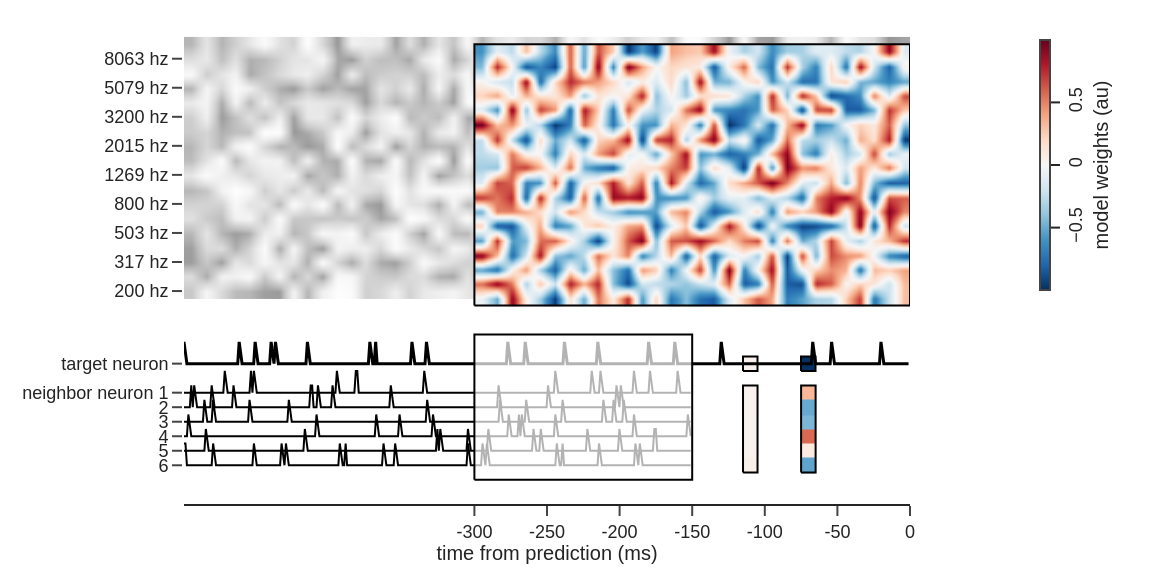

In [244]:
psth_scaling = 1.5
psth_start = 0
extra_resp = 2  # how much the response protrudes from the STRF. min 1
STRF_vert_offset = 5  # relative to the self PSTH
STRF_vert_scaling = 2  # size of the spectral channels
self_PSTH_vert_offset = 1  # relative to the last pop_psth
STRF_float = 0.5
cell_avg_lpad = 4
cell_weighs_lpad = 4

fig = go.Figure()

# add PSTHS for other neurons in the population
for ll, psth in enumerate(PSTHs):
    y = psth * psth_scaling + ll
    x = np.linspace(0, spectrogram.shape[1] - int(strf.shape[1] / 2), psth.shape[0], endpoint=False)

    fig.add_trace(
        go.Scatter(x=x, y=y,
                   mode='lines',
                   line=dict(
                       color='black',
                       width=1
                   ),
                   showlegend=False
                   )
    )

pop_ytickvals = list(range(nneur-1, -1, -1))
pop_yticktext = [f'neighbor neuron {ii+1}' if ii==0 else f'{ii+1}' for ii, _ in enumerate(pop_ytickvals)]

# Add PSTH for the predicted neuron
y = resp_psth * psth_scaling + nneur + self_PSTH_vert_offset
x = np.linspace(0, spectrogram.shape[1], resp_psth.shape[0], endpoint=False)
fig.add_trace(
    go.Scatter(x=x, y=y,
               mode='lines',
               opacity=1,
               line=dict(
                   color='black',
                   width=1.5
               ),
               showlegend=False
               )
)

resp_ytickvals = [nneur + self_PSTH_vert_offset]
resp_yticktext = [f'target neuron']


heamaps_y0 = nneur + self_PSTH_vert_offset + STRF_vert_offset
# spectrogram
fig.add_trace(go.Heatmap(z=spectrogram,
                         x0=0.5,
                         dx=1,
                         y0=heamaps_y0,
                         dy=1,
                         showscale=False,
                         coloraxis='coloraxis2',
                         opacity=1,
                         zsmooth='best',
                         )
              )

# STRF
strf_y0 = heamaps_y0 - STRF_float
fig.add_traces(heatmap_with_margin(z=strf[:, ::-1] * 2 - 1,
                         x0=extra + 0.5,
                         dx=1,
                         y0=strf_y0,
                         dy=1,
                         showscale=False,
                         coloraxis='coloraxis',
                         opacity=1,
                         zsmooth='best',
                         zmin=-1, zmid=0, zmax=1
                         )
              )

# ticks every second freq bin??
all_freqs = 2**np.linspace(0, spectrogram.shape[0]*1/3, spectrogram.shape[0], endpoint=False) * 200
strf_ytickvals = list(range(heamaps_y0, heamaps_y0+strf.shape[0], 2))
strf_yticktext = [f'{int(frq)} hz' for ii, frq in enumerate(all_freqs) if ii%2==0]


# average of population
x0 = extra + int(dur / 2) + cell_avg_lpad
dx = 1
y0 = 0
dy = 1
fig.add_traces(heatmap_with_margin(z=PSTHs_mean,
                         x0=x0, dx=dx,
                         y0=y0, dy=dy,
                         showscale=False,
                         coloraxis='coloraxis3')
              )

# population weight
x0 = extra + int(dur / 2) + cell_avg_lpad + cell_weighs_lpad
fig.add_traces(heatmap_with_margin(z=pop_weights,
                         x0=x0, dx=dx,
                         y0=y0, dy=dy,
                         showscale=False,
                         coloraxis='coloraxis3')
              )


# average of self
x0 = extra + int(dur / 2) + cell_avg_lpad
dx = 1
y0 = nneur + self_PSTH_vert_offset
dy = 1
fig.add_traces(heatmap_with_margin(z=resp_mean,
                         x0=x0, dx=dx,
                         y0=y0, dy=dy,
                         showscale=False,
                         coloraxis='coloraxis3')
              )

# self weight
x0 = extra + int(dur / 2) + cell_avg_lpad + cell_weighs_lpad
fig.add_traces(heatmap_with_margin(z=self_weight,
                         x0=x0, dx=dx,
                         y0=y0, dy=dy,
                         showscale=False,
                         coloraxis='coloraxis3')
              )

# box around all PSTHs
x0 = extra
dx = int(strf.shape[1] / 2)
x = np.array([x0, x0 + dx, x0 + dx, x0, x0])
y0 = -0.5
dy = nneur + self_PSTH_vert_offset + psth_scaling * 2
y = np.array([y0, y0, y0 + dy, y0 + dy, y0]) - 0.5
fig.add_trace(go.Scatter(x=x, y=y,
                   mode='lines',
                   line=dict(color='black',
                             dash='solid',
                             width=1),
                   showlegend=False,
                   fill='toself', fillcolor='rgba(256,256,256,0.7)'
                   ))



ytickvals = pop_ytickvals + resp_ytickvals + strf_ytickvals
yticktext = pop_yticktext + resp_yticktext + strf_yticktext


w, h = 6, 3
fig.update_layout(width=w * 96, height=h * 96,
                  margin=dict(b=10, t=10, l=10, r=10),
                  template='simple_white',
                  coloraxis=dict(showscale=True,
                                 colorscale='RdBu',
                                 cmid=0,
                                 reversescale=True,
                                 colorbar=dict(
                                     thickness=5, len=0.6,
                                     title=dict(text='model weights (au)',
                                                font_size=10,
                                                side='right'),
                                     tickfont_size=9,
                                     tickangle = -90,
                                     xanchor='left',
                                     x=1,
                                     yanchor='top',
                                     y=1
                                 )),

                  coloraxis2=dict(showscale=False,
                                  colorscale='greys',
                                  cmid=0,
                                  reversescale=True),
                  coloraxis3=dict(showscale=False,
                                  colorscale='RdBu',
                                  cmid=0,
                                  reversescale=True),

                  xaxis=dict(autorange=True,
                             constrain='domain',
                             tickmode='array',
                             tickvals=np.asarray([0, 5, 10, 15, 20, 25, 30]) + extra,
                             ticktext=[-300, -250, -200, -150, -100, -50, 0],
                             tickfont_size=9,
                             title=dict(text='time from prediction (ms)',
                                        standoff=0,
                                        font_size=10)
                             ),

                  yaxis=dict(scaleanchor='x',
                             # showticklabels=False,
                             # ticks='',
                             tickmode='array',
                             tickvals=ytickvals,
                             ticktext=yticktext,
                             tickfont_size=9,
                             showline=False,
                             constrain='domain'),

                  )

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

# filename = folder / 'fig4_model_schematic'
# fig.write_image(filename.with_suffix('.png'))
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=w * 96, height=h * 96,
                         scale=2
                         )
Image(img_bytes)